# IMPROVED TRAINING AND TESTING FRAMEWORK

## SETUP

In [5]:
!pip install transformers torch

  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached torch-2.6.0-cp39-cp39-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.29.2-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import spacy
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model for entity extraction
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("Installing spaCy model...")
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


[nltk_data] Downloading package punkt to /home/matejas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matejas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## DATA LOADING

In [7]:
# Load datasets
def load_data():
    # Load synthetic dataset (real articles and their synthesized fake versions)
    synthetic_data = pd.read_csv('vaccination_synthetic_articles_combined.csv')
    
    # Load standard fake news dataset
    standard_data = pd.read_csv('MMCoVaR_News_Dataset.csv')
    
    # Basic data cleaning
    synthetic_data = synthetic_data.dropna(subset=['Changed_article', 'Original_article'])
    standard_data = standard_data.dropna(subset=['body_text', 'reliability'])
    
    # Prepare synthetic dataset
    original_articles = synthetic_data[['Original_article']].copy()
    original_articles['label'] = 1  # Real
    original_articles.rename(columns={'Original_article': 'text'}, inplace=True)
    
    changed_articles = synthetic_data[['Changed_article']].copy()
    changed_articles['label'] = 0  # Fake
    changed_articles.rename(columns={'Changed_article': 'text'}, inplace=True)
    
    # Prepare standard dataset
    real_articles = standard_data[standard_data['reliability'] == 1][['body_text']].copy()
    real_articles['label'] = 1  # Real
    real_articles.rename(columns={'body_text': 'text'}, inplace=True)
    
    fake_articles = standard_data[standard_data['reliability'] == 0][['body_text']].copy()
    fake_articles['label'] = 0  # Fake
    fake_articles.rename(columns={'body_text': 'text'}, inplace=True)
    
    # Create dataset combinations
    # 1. Only synthetic dataset
    synthetic_only = pd.concat([original_articles, changed_articles]).sample(frac=1, random_state=RANDOM_SEED)
    
    # 2. Only standard dataset
    standard_only = pd.concat([
        real_articles.sample(n=min(len(real_articles), 900), random_state=RANDOM_SEED),
        fake_articles.sample(n=min(len(fake_articles), 900), random_state=RANDOM_SEED)
    ]).sample(frac=1, random_state=RANDOM_SEED)
    
    # 3. Combined dataset with balanced classes
    combined_balanced = pd.concat([
        pd.concat([original_articles, real_articles]).sample(n=1000, random_state=RANDOM_SEED),
        pd.concat([changed_articles, fake_articles]).sample(n=1000, random_state=RANDOM_SEED)
    ]).sample(frac=1, random_state=RANDOM_SEED)
    
    # 4. Strategic combination (for controlled experiments)
    strategic_combo = {
        'original_articles': original_articles,
        'changed_articles': changed_articles,
        'real_articles': real_articles,
        'fake_articles': fake_articles
    }
    
    return {
        'synthetic_only': synthetic_only,
        'standard_only': standard_only,
        'combined_balanced': combined_balanced,
        'strategic_combo': strategic_combo
    }

datasets = load_data()

## FEATURE EXTRACTION METHODS

### Base TF-IDF Features

In [8]:
# Base TF-IDF Features
class TfidfFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=5000, ngram_range=(1, 2)):
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english'
        )
    
    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self
    
    def transform(self, X):
        return self.vectorizer.transform(X)


### Entity-based Features

In [9]:
# Entity-based Features
class EntityFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.entity_types = ['PERSON', 'ORG', 'GPE', 'DATE', 'CARDINAL', 'PERCENT', 'MONEY']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = []
        for text in X:
            # Process with spaCy to get entities
            doc = nlp(text[:10000])  # Limit text length for efficiency
            
            # Count entities by type
            entity_counts = {ent_type: 0 for ent_type in self.entity_types}
            for ent in doc.ents:
                if ent.label_ in entity_counts:
                    entity_counts[ent.label_] += 1
            
            # Create features: absolute counts and ratios
            total_words = len(text.split())
            feature_vector = []
            
            # Add absolute counts
            for ent_type in self.entity_types:
                feature_vector.append(entity_counts[ent_type])
            
            # Add entity ratios (per 100 words)
            for ent_type in self.entity_types:
                ratio = (entity_counts[ent_type] / (total_words + 1)) * 100
                feature_vector.append(ratio)
            
            # Total entity count & ratio
            total_entities = sum(entity_counts.values())
            feature_vector.append(total_entities)
            feature_vector.append((total_entities / (total_words + 1)) * 100)
            
            features.append(feature_vector)
        
        return np.array(features)


### Stylometric Features

In [10]:
class StyleFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = []
        for text in X:
            # Basic text stats
            sentences = text.split('.')
            words = text.split()
            chars = len(text)
            
            # Calculate features
            avg_sentence_length = len(words) / (len(sentences) + 1)
            avg_word_length = chars / (len(words) + 1)
            
            # Count punctuation
            exclamation_count = text.count('!')
            question_count = text.count('?')
            comma_count = text.count(',')
            
            # Count uppercase words
            uppercase_ratio = sum(1 for word in words if word.isupper()) / (len(words) + 1)
            
            # Create the feature vector
            feature_vector = [
                avg_sentence_length,
                avg_word_length,
                exclamation_count / (len(sentences) + 1),
                question_count / (len(sentences) + 1),
                comma_count / (len(sentences) + 1),
                uppercase_ratio
            ]
            
            features.append(feature_vector)
        
        return np.array(features)

### Fact Verification

In [11]:
# Add this to the "Feature Extraction Methods" section
class FactVerificationFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        
    def fit(self, X, y=None):
        return self
    
    def extract_facts(self, text):
        doc = self.nlp(text[:5000])  # Limit text length for efficiency
        facts = []
        
        for sent in doc.sents:
            for token in sent:
                if token.dep_ == "nsubj" and token.head.pos_ == "VERB":
                    subj = token.text
                    verb = token.head.text
                    obj = ""
                    
                    for child in token.head.children:
                        if child.dep_ in ["dobj", "attr", "prep"]:
                            obj_tokens = [child.text] + [t.text for t in child.subtree]
                            obj = " ".join(obj_tokens)
                            break
                    
                    if obj:
                        facts.append((subj, verb, obj))
        
        return facts
    
    def transform(self, X):
        features = []
        for text in X:
            try:
                # Process text to extract fact-related features
                doc = self.nlp(text[:5000])
                facts = self.extract_facts(text)
                
                # Get entities and their types
                entities = [(ent.text, ent.label_) for ent in doc.ents]
                person_entities = [e for e, l in entities if l == "PERSON"]
                org_entities = [e for e, l in entities if l == "ORG"]
                date_entities = [e for e, l in entities if l == "DATE"]
                
                # Create feature vector
                feature_vec = [
                    len(facts),  # Total facts
                    len(facts) / max(1, len(list(doc.sents))),  # Facts per sentence
                    len(entities) / max(1, len(facts)),  # Entities per fact
                    len(person_entities) / max(1, len(entities) + 1),  # Person ratio
                    len(date_entities) / max(1, len(entities) + 1),  # Date ratio
                    len(org_entities) / max(1, len(entities) + 1),  # Organization ratio
                ]
                
                features.append(feature_vec)
            except Exception as e:
                print(f"Error processing text: {e}")
                features.append([0, 0, 0, 0, 0, 0])  # Default values on error
                
        return np.array(features)

### Combined Feature Extractor

In [12]:
# Update this function in the Feature Extraction section
def create_feature_extractor(use_tfidf=True, use_entities=True, use_style=True, 
                           use_fact_verification=False, max_features=5000):
    features = []
    
    if use_tfidf:
        features.append(('tfidf', TfidfFeatures(max_features=max_features)))
    
    if use_entities:
        features.append(('entities', EntityFeatures()))
    
    if use_style:
        features.append(('style', StyleFeatures()))
        
    if use_fact_verification:
        features.append(('facts', FactVerificationFeatures()))
    
    # If only one feature set is requested, don't use FeatureUnion
    if len(features) == 1:
        return features[0][1]
    
    return FeatureUnion(features)

## MODEL IMPLEMENTATIONS

### Two stage classification

In [13]:
class TwoStageClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=RANDOM_SEED):
        self.random_state = random_state
        
        # First classifier for traditional fake news (good with stylistic differences)
        self.traditional_clf = MultinomialNB()
        
        # Second classifier for subtle fact manipulation (good with synthetic differences)
        self.synthetic_clf = SVC(probability=True, random_state=random_state)
        
        # Features for both classifiers
        self.trad_features = TfidfVectorizer(max_features=5000)
        self.synth_features = FactVerificationFeatures()
    
    def fit(self, X, y):
        # Prepare features for both classifiers
        X_trad = self.trad_features.fit_transform(X)
        X_synth = self.synth_features.fit_transform(X)
        
        # Train both classifiers
        self.traditional_clf.fit(X_trad, y)
        self.synthetic_clf.fit(X_synth, y)
        
        return self
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)
    
    def predict_proba(self, X):
        # Get probabilities from both classifiers
        X_trad = self.trad_features.transform(X)
        X_synth = self.synth_features.transform(X)
        
        trad_proba = self.traditional_clf.predict_proba(X_trad)
        synth_proba = self.synthetic_clf.predict_proba(X_synth)
        
        # Combine probabilities (weighted average)
        combined_proba = 0.6 * trad_proba + 0.4 * synth_proba
        
        return combined_proba

In [14]:
def create_model(model_type, random_state=RANDOM_SEED, **kwargs):
    if model_type == 'nb':
        return MultinomialNB(**kwargs)
    elif model_type == 'lr':
        return LogisticRegression(random_state=random_state, max_iter=1000, **kwargs)
    elif model_type == 'svm':
        return SVC(probability=True, random_state=random_state, **kwargs)
    elif model_type == 'mlp':
        return MLPClassifier(random_state=random_state, max_iter=300, **kwargs)
    elif model_type == 'rf':
        return RandomForestClassifier(random_state=random_state, **kwargs)
    elif model_type == 'gb':
        return GradientBoostingClassifier(random_state=random_state, **kwargs)
    elif model_type == 'two_stage':
        return TwoStageClassifier(random_state=random_state, **kwargs)
    elif model_type == 'ensemble':
        if 'model' in kwargs:
            return kwargs['model']
        return VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(random_state=random_state)),
                ('rf', RandomForestClassifier(random_state=random_state)),
                ('svm', SVC(probability=True, random_state=random_state))
            ],
            voting='soft'
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")


# Function to create complete pipeline (feature extraction + model)
def create_pipeline(model_type, feature_config, **model_kwargs):
    feature_extractor = create_feature_extractor(**feature_config)
    model = create_model(model_type, **model_kwargs)
    return Pipeline([
        ('features', feature_extractor),
        ('model', model)
    ])

def create_ensemble(models_list):
    estimators = []
    for i, (model_type, feature_config, model_kwargs) in enumerate(models_list):
        # Create a complete pipeline for each model to ensure proper data flow
        features = create_feature_extractor(**feature_config)
        model = create_model(model_type, **model_kwargs)
        pipe = Pipeline([
            ('features', features),
            ('model', model)
        ])
        estimators.append((f"{model_type}_{i}", pipe))
    
    return VotingClassifier(estimators=estimators, voting='soft')

## BERT classifier

In [15]:
class BertClassifier:
    def __init__(self, model_name='bert-base-uncased', max_length=256, batch_size=16, epochs=3):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        self.model.to(self.device)
        self.max_length = max_length
        self.batch_size = batch_size
        self.epochs = epochs
        
    def fit(self, X, y):
        # Tokenize all texts
        encodings = self.tokenizer(list(X), truncation=True, padding=True, 
                                   max_length=self.max_length, return_tensors='pt')
        
        # Create dataset
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)
        labels = torch.tensor(y.values).to(self.device)
        dataset = TensorDataset(input_ids, attention_mask, labels)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Setup optimizer
        optimizer = AdamW(self.model.parameters(), lr=5e-5)
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            print(f"Epoch {epoch+1}/{self.epochs}")
            
            for batch_idx, (batch_input_ids, batch_attention_mask, batch_labels) in enumerate(loader):
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask,
                    labels=batch_labels
                )
                
                # Get loss and backpropagate
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                
                # Update parameters
                optimizer.step()
                
                # Print progress
                if (batch_idx + 1) % 5 == 0:
                    print(f"  Batch {batch_idx+1}/{len(loader)}, Loss: {loss.item():.4f}")
            
            avg_loss = total_loss / len(loader)
            print(f"  Average loss: {avg_loss:.4f}")
        
        return self
    
    def predict(self, X):
        # Switch to evaluation mode
        self.model.eval()
        
        # Tokenize all texts
        encodings = self.tokenizer(list(X), truncation=True, padding=True, 
                                  max_length=self.max_length, return_tensors='pt')
        
        # Create dataset without labels
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)
        dataset = TensorDataset(input_ids, attention_mask)
        loader = DataLoader(dataset, batch_size=self.batch_size)
        
        # Make predictions
        predictions = []
        
        with torch.no_grad():
            for batch_input_ids, batch_attention_mask in loader:
                outputs = self.model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask
                )
                
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
        
        return predictions
    
    def predict_proba(self, X):
        # Switch to evaluation mode
        self.model.eval()
        
        # Tokenize all texts
        encodings = self.tokenizer(list(X), truncation=True, padding=True, 
                                  max_length=self.max_length, return_tensors='pt')
        
        # Create dataset without labels
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)
        dataset = TensorDataset(input_ids, attention_mask)
        loader = DataLoader(dataset, batch_size=self.batch_size)
        
        # Make predictions
        all_probs = []
        
        with torch.no_grad():
            for batch_input_ids, batch_attention_mask in loader:
                outputs = self.model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask
                )
                
                logits = outputs.logits
                probs = torch.softmax(logits, dim=1).cpu().numpy()
                all_probs.extend(probs)
        
        return np.array(all_probs)



## TRAINING STRATEGIES

### BASIC TRAINING

In [16]:
# Basic train/test split training
def train_test_evaluate(pipeline, X_train, y_train, X_test, y_test):
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return {
        'pipeline': pipeline,
        'predictions': y_pred,
        'report': report,
        'confusion_matrix': conf_matrix,
        'accuracy': report['accuracy'],
        'f1_weighted': report['weighted avg']['f1-score']
    }

### CURRICULUM LEARNING

In [17]:
# Curriculum learning implementation
def curriculum_learning(base_model_type, target_model_type, feature_config,
                       easy_X_train, easy_y_train, hard_X_train, hard_y_train, 
                       X_test, y_test, **model_kwargs):
    
    # Stage 1: Train on "easy" examples (regular fake news)
    stage1_pipeline = create_pipeline(base_model_type, feature_config, **model_kwargs)
    stage1_pipeline.fit(easy_X_train, easy_y_train)
    
    # Extract learned parameters from Stage 1 model
    # (This will be model-specific - this is just a conceptual example)
    if base_model_type == 'lr' and target_model_type == 'lr':
        # Copy coefficients from first model to second
        base_coef = stage1_pipeline.named_steps['model'].coef_
        base_intercept = stage1_pipeline.named_steps['model'].intercept_
        
        # Stage 2: Continue training on "hard" examples (synthetic fake news)
        stage2_pipeline = create_pipeline(target_model_type, feature_config, **model_kwargs)
        # Initialize with parameters from first stage before fitting
        stage2_pipeline.fit(hard_X_train, hard_y_train)
        stage2_pipeline.named_steps['model'].coef_ = base_coef * 0.5 + stage2_pipeline.named_steps['model'].coef_ * 0.5
        stage2_pipeline.named_steps['model'].intercept_ = base_intercept * 0.5 + stage2_pipeline.named_steps['model'].intercept_ * 0.5
    else:
        # For other model types, just train sequentially without parameter transfer
        stage2_pipeline = create_pipeline(target_model_type, feature_config, **model_kwargs)
        stage2_pipeline.fit(hard_X_train, hard_y_train)
    
    # Evaluate
    y_pred = stage2_pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return {
        'pipeline': stage2_pipeline,
        'predictions': y_pred,
        'report': report,
        'confusion_matrix': conf_matrix,
        'accuracy': report['accuracy'],
        'f1_weighted': report['weighted avg']['f1-score']
    }

### WEIGHTED SAMPLING

In [18]:
# Weighted sampling approach
def train_with_weighted_sampling(pipeline, strategic_combo, synthetic_ratio=0.5, test_size=0.2):
    # Get the component datasets
    original_articles = strategic_combo['original_articles']
    changed_articles = strategic_combo['changed_articles']
    real_articles = strategic_combo['real_articles']
    fake_articles = strategic_combo['fake_articles']
    
    # Determine sample sizes
    real_synth_size = min(len(original_articles), 300)
    fake_synth_size = min(len(changed_articles), 300)
    real_standard_size = min(len(real_articles), 300)
    fake_standard_size = min(len(fake_articles), 300)
    
    # Sample from each dataset
    sampled_original = original_articles.sample(n=real_synth_size, random_state=RANDOM_SEED)
    sampled_changed = changed_articles.sample(n=fake_synth_size, random_state=RANDOM_SEED)
    sampled_real = real_articles.sample(n=real_standard_size, random_state=RANDOM_SEED)
    sampled_fake = fake_articles.sample(n=fake_standard_size, random_state=RANDOM_SEED)
    
    # Calculate synthetic vs. standard split based on ratio
    synthetic_count = int((real_synth_size + fake_synth_size) * synthetic_ratio)
    standard_count = (real_synth_size + fake_synth_size) - synthetic_count
    
    # Adjust individual sample sizes
    synth_real_adjusted = min(real_synth_size, int(synthetic_count / 2))
    synth_fake_adjusted = min(fake_synth_size, synthetic_count - synth_real_adjusted)
    standard_real_adjusted = min(real_standard_size, int(standard_count / 2))
    standard_fake_adjusted = min(fake_standard_size, standard_count - standard_real_adjusted)
    
    # Re-sample with adjusted sizes
    sampled_original = original_articles.sample(n=synth_real_adjusted, random_state=RANDOM_SEED)
    sampled_changed = changed_articles.sample(n=synth_fake_adjusted, random_state=RANDOM_SEED)
    sampled_real = real_articles.sample(n=standard_real_adjusted, random_state=RANDOM_SEED)
    sampled_fake = fake_articles.sample(n=standard_fake_adjusted, random_state=RANDOM_SEED)
    
    # Combine samples
    combined_real = pd.concat([sampled_original, sampled_real])
    combined_fake = pd.concat([sampled_changed, sampled_fake])
    
    # Create the final training dataset
    X_all = pd.concat([combined_real, combined_fake])
    y_all = X_all['label']
    X_all = X_all['text']
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=RANDOM_SEED, stratify=y_all
    )
    
    # Train and evaluate
    return train_test_evaluate(pipeline, X_train, y_train, X_test, y_test)

### Contrastive learning approach

In [19]:
def train_with_contrastive_learning(strategic_combo, test_size=0.2):
    # Get component datasets
    original_articles = strategic_combo['original_articles']
    changed_articles = strategic_combo['changed_articles']
    real_articles = strategic_combo['real_articles']
    fake_articles = strategic_combo['fake_articles']
    
    # We need to make sure we have matching pairs of original/changed articles
    min_synth_size = min(len(original_articles), len(changed_articles))
    
    # Sample from each dataset
    sampled_original = original_articles.sample(n=min_synth_size, random_state=RANDOM_SEED)
    sampled_changed = changed_articles.sample(n=min_synth_size, random_state=RANDOM_SEED)
    
    # Create a DataFrame of paired articles
    pairs = pd.DataFrame({
        'original': sampled_original['text'].reset_index(drop=True),
        'changed': sampled_changed['text'].reset_index(drop=True)
    })
    
    # TF-IDF vectorizer to represent articles
    vectorizer = TfidfVectorizer(max_features=1000)
    all_texts = np.concatenate([pairs['original'], pairs['changed']])
    vectorizer.fit(all_texts)
    
    # Create pairwise difference features
    X_diff = []
    y_diff = []
    
    # Add positive pairs (both real articles)
    for i in range(min(min_synth_size, 100)):  # Limit to 100 positive examples
        for j in range(i+1, min(min_synth_size, 100)):
            text1 = pairs['original'].iloc[i]
            text2 = pairs['original'].iloc[j]
            
            vec1 = vectorizer.transform([text1]).toarray().flatten()
            vec2 = vectorizer.transform([text2]).toarray().flatten()
            
            # Use absolute difference as features
            diff = np.abs(vec1 - vec2)
            X_diff.append(diff)
            y_diff.append(1)  # Same class (both real)
    
    # Add negative pairs (original vs. changed)
    for i in range(min_synth_size):
        text1 = pairs['original'].iloc[i]
        text2 = pairs['changed'].iloc[i]
        
        vec1 = vectorizer.transform([text1]).toarray().flatten()
        vec2 = vectorizer.transform([text2]).toarray().flatten()
        
        diff = np.abs(vec1 - vec2)
        X_diff.append(diff)
        y_diff.append(0)  # Different classes (real vs fake)
    
    # Train a model on these differences
    X_diff = np.array(X_diff)
    y_diff = np.array(y_diff)
    
    X_diff_train, X_diff_test, y_diff_train, y_diff_test = train_test_split(
        X_diff, y_diff, test_size=test_size, random_state=RANDOM_SEED
    )
    
    diff_model = SVC(probability=True, random_state=RANDOM_SEED)
    diff_model.fit(X_diff_train, y_diff_train)
    
    # Create a test set for full article classification
    sampled_real = real_articles.sample(n=min(len(real_articles), 200), random_state=RANDOM_SEED)
    sampled_fake = fake_articles.sample(n=min(len(fake_articles), 200), random_state=RANDOM_SEED)
    
    X_test = pd.concat([sampled_real['text'], sampled_fake['text']])
    y_test = pd.concat([sampled_real['label'], sampled_fake['label']])
    
    # Create a classifier that uses the difference model
    def contrastive_predict(texts, ref_texts=pairs['original'].tolist()):
        y_pred = []
        
        for text in texts:
            text_vec = vectorizer.transform([text]).toarray().flatten()
            
            # Compare with reference texts (known real articles)
            similarities = []
            for ref_text in ref_texts[:20]:  # Use first 20 reference texts
                ref_vec = vectorizer.transform([ref_text]).toarray().flatten()
                diff = np.abs(text_vec - ref_vec)
                pred = diff_model.predict_proba([diff])[0][1]  # Probability of being same class
                similarities.append(pred)
            
            # If text is similar to many reference texts, likely real
            avg_similarity = np.mean(similarities)
            y_pred.append(1 if avg_similarity > 0.5 else 0)
        
        return np.array(y_pred)
    
    # Evaluate on test set
    y_pred = contrastive_predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    report = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': (vectorizer, diff_model, pairs['original'].tolist())
    }
    
    return report

## HYPOTHESIS TESTING FRAMEWORK

In [20]:
# Update the test_hypothesis function to handle the two-stage classifier
def test_hypothesis(model_type, feature_config, strategic_combo, n_folds=5, **model_kwargs):
    # Get the component datasets
    original_articles = strategic_combo['original_articles']
    changed_articles = strategic_combo['changed_articles']
    real_articles = strategic_combo['real_articles']
    fake_articles = strategic_combo['fake_articles']
    
    # Create baseline dataset (without synthetic)
    baseline_real = real_articles.sample(n=min(len(real_articles), 400), random_state=RANDOM_SEED)
    baseline_fake = fake_articles.sample(n=min(len(fake_articles), 400), random_state=RANDOM_SEED)
    baseline_data = pd.concat([baseline_real, baseline_fake])
    
    # Create enhanced dataset (with synthetic)
    enhanced_real = pd.concat([
        real_articles.sample(n=min(len(real_articles), 300), random_state=RANDOM_SEED),
        original_articles.sample(n=min(len(original_articles), 100), random_state=RANDOM_SEED)
    ])
    enhanced_fake = pd.concat([
        fake_articles.sample(n=min(len(fake_articles), 300), random_state=RANDOM_SEED),
        changed_articles.sample(n=min(len(changed_articles), 100), random_state=RANDOM_SEED)
    ])
    enhanced_data = pd.concat([enhanced_real, enhanced_fake])
    
    # Shuffle both datasets
    baseline_data = baseline_data.sample(frac=1, random_state=RANDOM_SEED)
    enhanced_data = enhanced_data.sample(frac=1, random_state=RANDOM_SEED)
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
    
    # Results storage
    baseline_metrics = []
    enhanced_metrics = []
    
    # Special handling for two_stage classifier
    if model_type == 'two_stage':
        # Create the classifier directly instead of using pipeline
        classifier = TwoStageClassifier(random_state=RANDOM_SEED)
        
        # Baseline cross-validation
        for train_idx, test_idx in skf.split(baseline_data['text'], baseline_data['label']):
            X_train = baseline_data['text'].iloc[train_idx].values
            X_test = baseline_data['text'].iloc[test_idx].values
            y_train = baseline_data['label'].iloc[train_idx].values
            y_test = baseline_data['label'].iloc[test_idx].values
            
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            baseline_metrics.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
        
        # Enhanced cross-validation
        for train_idx, test_idx in skf.split(enhanced_data['text'], enhanced_data['label']):
            X_train = enhanced_data['text'].iloc[train_idx].values
            X_test = enhanced_data['text'].iloc[test_idx].values
            y_train = enhanced_data['label'].iloc[train_idx].values
            y_test = enhanced_data['label'].iloc[test_idx].values
            
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            enhanced_metrics.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
    else:
        # Original code for other model types
        # Baseline cross-validation
        for train_idx, test_idx in skf.split(baseline_data['text'], baseline_data['label']):
            # Create train/test split
            X_train, X_test = baseline_data['text'].iloc[train_idx], baseline_data['text'].iloc[test_idx]
            y_train, y_test = baseline_data['label'].iloc[train_idx], baseline_data['label'].iloc[test_idx]
            
            # Train model
            pipeline = create_pipeline(model_type, feature_config, **model_kwargs)
            pipeline.fit(X_train, y_train)
            
            # Evaluate
            y_pred = pipeline.predict(X_test)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            
            baseline_metrics.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
        
        # Enhanced cross-validation
        for train_idx, test_idx in skf.split(enhanced_data['text'], enhanced_data['label']):
            # Create train/test split
            X_train, X_test = enhanced_data['text'].iloc[train_idx], enhanced_data['text'].iloc[test_idx]
            y_train, y_test = enhanced_data['label'].iloc[train_idx], enhanced_data['label'].iloc[test_idx]
            
            # Train model
            pipeline = create_pipeline(model_type, feature_config, **model_kwargs)
            pipeline.fit(X_train, y_train)
            
            # Evaluate
            y_pred = pipeline.predict(X_test)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            
            enhanced_metrics.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
    
    # Compute averages
    baseline_avg = {
        metric: np.mean([fold[metric] for fold in baseline_metrics])
        for metric in ['accuracy', 'precision', 'recall', 'f1']
    }
    enhanced_avg = {
        metric: np.mean([fold[metric] for fold in enhanced_metrics])
        for metric in ['accuracy', 'precision', 'recall', 'f1']
    }
    
    # Calculate improvement
    improvement = {
        metric: enhanced_avg[metric] - baseline_avg[metric]
        for metric in ['accuracy', 'precision', 'recall', 'f1']
    }
    
    return {
        'baseline': baseline_avg,
        'enhanced': enhanced_avg,
        'improvement': improvement,
        'baseline_folds': baseline_metrics,
        'enhanced_folds': enhanced_metrics
    }

## VISUALISATION UTILITIES

In [21]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot metrics comparison
def plot_metrics_comparison(baseline, enhanced, title='Model Performance Comparison'):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax.bar(x - width/2, [baseline[m] for m in metrics], width, label='Without Synthetic')
    ax.bar(x + width/2, [enhanced[m] for m in metrics], width, label='With Synthetic')
    
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    # Add value labels on bars
    for i, v in enumerate([baseline[m] for m in metrics]):
        ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')
    
    for i, v in enumerate([enhanced[m] for m in metrics]):
        ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')
    
    # Add improvement percentages
    for i, (m_base, m_enh) in enumerate(zip([baseline[m] for m in metrics], [enhanced[m] for m in metrics])):
        improvement = (m_enh - m_base) / m_base * 100
        ax.text(i, max(m_base, m_enh) + 0.03, f'{improvement:+.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()

## EXPERIMENT RUNNER

In [25]:
# Function for feature configuration experiments
def run_feature_experiments(strategic_combo):
    results = {}
    feature_configs = [
        {'use_tfidf': True, 'use_entities': False, 'use_style': False},  # TF-IDF only
        {'use_tfidf': True, 'use_entities': True, 'use_style': False},   # TF-IDF + Entities
        {'use_tfidf': True, 'use_entities': True, 'use_style': True},    # All features
    ]
    
    for i, feature_config in enumerate(feature_configs):
        print(f"Testing feature configuration {i+1}/{len(feature_configs)}")
        result = test_hypothesis('lr', feature_config, strategic_combo, n_folds=3)
        results[f'feature_config_{i+1}'] = result
        
        print(f"  Without synthetic: Accuracy={result['baseline']['accuracy']:.3f}, F1={result['baseline']['f1']:.3f}")
        print(f"  With synthetic: Accuracy={result['enhanced']['accuracy']:.3f}, F1={result['enhanced']['f1']:.3f}")
        print(f"  Improvement: Accuracy={result['improvement']['accuracy']:.3f}, F1={result['improvement']['f1']:.3f}")
    
    return results

# Function for model comparison experiments
def run_model_experiments(strategic_combo, best_feature_config):
    results = {}
    models = ['nb', 'lr', 'svm', 'mlp', 'rf']
    
    for model_type in models:
        print(f"Testing model: {model_type}")
        result = test_hypothesis(model_type, best_feature_config, strategic_combo, n_folds=3)
        results[f'model_{model_type}'] = result
        
        print(f"  Without synthetic: Accuracy={result['baseline']['accuracy']:.3f}, F1={result['baseline']['f1']:.3f}")
        print(f"  With synthetic: Accuracy={result['enhanced']['accuracy']:.3f}, F1={result['enhanced']['f1']:.3f}")
        print(f"  Improvement: Accuracy={result['improvement']['accuracy']:.3f}, F1={result['improvement']['f1']:.3f}")
    
    return results

# Function for synthetic ratio experiments
def run_ratio_experiments(strategic_combo, best_model, best_feature_config):
    results = {}
    ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    for ratio in ratios:
        print(f"Testing synthetic ratio: {ratio}")
        pipeline = create_pipeline(best_model, best_feature_config)
        result = train_with_weighted_sampling(pipeline, strategic_combo, synthetic_ratio=ratio)
        results[f'ratio_{ratio}'] = result
        
        print(f"  Accuracy={result['accuracy']:.3f}, F1={result['f1_weighted']:.3f}")
    
    return results

# Function for ensemble experiment
def run_ensemble_experiment(strategic_combo, best_feature_config):
    print("Testing ensemble model")
    ensemble_models = [
        ('nb', best_feature_config, {}),
        ('lr', best_feature_config, {}),
        ('svm', best_feature_config, {})
    ]
    
    ensemble = create_ensemble(ensemble_models)
    
    result = test_hypothesis('ensemble', best_feature_config, strategic_combo, 
                          n_folds=3, model=ensemble)
    
    print(f"  Without synthetic: Accuracy={result['baseline']['accuracy']:.3f}, F1={result['baseline']['f1']:.3f}")
    print(f"  With synthetic: Accuracy={result['enhanced']['accuracy']:.3f}, F1={result['enhanced']['f1']:.3f}")
    print(f"  Improvement: Accuracy={result['improvement']['accuracy']:.3f}, F1={result['improvement']['f1']:.3f}")
    
    return result

# Function to run advanced experiments
def run_advanced_experiments():
    results = {}
    
    # Get strategic dataset components
    strategic_combo = datasets['strategic_combo']
    
    # Test fact verification features
    print("Testing fact verification features")
    feature_config = {'use_tfidf': True, 'use_entities': False, 'use_style': False, 'use_fact_verification': True}
    result = test_hypothesis('svm', feature_config, strategic_combo, n_folds=3)
    results['fact_verification'] = result
    
    # Print summary
    print(f"  Without synthetic: Accuracy={result['baseline']['accuracy']:.3f}, F1={result['baseline']['f1']:.3f}")
    print(f"  With synthetic: Accuracy={result['enhanced']['accuracy']:.3f}, F1={result['enhanced']['f1']:.3f}")
    print(f"  Improvement: Accuracy={result['improvement']['accuracy']:.3f}, F1={result['improvement']['f1']:.3f}")
    print()
    
    # Test two-stage classifier
    print("Testing two-stage classifier")
    result = test_hypothesis('two_stage', {'use_tfidf': True}, strategic_combo, n_folds=3)
    results['two_stage'] = result
    
    # Print summary
    print(f"  Without synthetic: Accuracy={result['baseline']['accuracy']:.3f}, F1={result['baseline']['f1']:.3f}")
    print(f"  With synthetic: Accuracy={result['enhanced']['accuracy']:.3f}, F1={result['enhanced']['f1']:.3f}")
    print(f"  Improvement: Accuracy={result['improvement']['accuracy']:.3f}, F1={result['improvement']['f1']:.3f}")
    print()
    
    # Test contrastive learning
    print("Testing contrastive learning approach")
    result = train_with_contrastive_learning(strategic_combo)
    results['contrastive'] = result
    
    # Print summary
    print(f"  Accuracy={result['accuracy']:.3f}, F1={result['f1']:.3f}")
    print()
    
    return results


# Run a more comprehensive BERT experiment with finer-grained ratios
def test_bert_synthetic_transfer_comprehensive(strategic_combo, ratios=[0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]):
    results = {}
    
    # Get the component datasets
    original_articles = strategic_combo['original_articles']
    changed_articles = strategic_combo['changed_articles']
    real_articles = strategic_combo['real_articles']
    fake_articles = strategic_combo['fake_articles']
    
    # Create a test set of only standard real/fake news
    test_real = real_articles.sample(n=min(len(real_articles), 100), random_state=RANDOM_SEED+1)
    test_fake = fake_articles.sample(n=min(len(fake_articles), 100), random_state=RANDOM_SEED+1)
    test_data = pd.concat([test_real, test_fake]).sample(frac=1, random_state=RANDOM_SEED)
    
    # Remove test data from our available standard data
    remaining_real = real_articles[~real_articles.index.isin(test_real.index)]
    remaining_fake = fake_articles[~fake_articles.index.isin(test_fake.index)]
    
    # Test each synthetic ratio (including 0 for baseline)
    for ratio in ratios:
        print(f"\nTesting BERT with synthetic ratio: {ratio:.1f}")
        
        # For ratio 0, we just use standard data
        if ratio == 0:
            print("Creating baseline (0% synthetic)...")
            train_real = remaining_real.sample(n=min(len(remaining_real), 150), random_state=RANDOM_SEED)
            train_fake = remaining_fake.sample(n=min(len(remaining_fake), 150), random_state=RANDOM_SEED)
        else:
            # Calculate sample sizes based on ratio
            total_train_samples = 300  # 150 per class to keep training faster
            synth_samples = int(total_train_samples/2 * ratio)
            std_samples = int(total_train_samples/2) - synth_samples
            
            # Create training dataset with specific ratio
            train_real_std = remaining_real.sample(n=min(len(remaining_real), std_samples), random_state=RANDOM_SEED)
            train_fake_std = remaining_fake.sample(n=min(len(remaining_fake), std_samples), random_state=RANDOM_SEED)
            
            train_real_synth = original_articles.sample(n=min(len(original_articles), synth_samples), random_state=RANDOM_SEED)
            train_fake_synth = changed_articles.sample(n=min(len(changed_articles), synth_samples), random_state=RANDOM_SEED)
            
            train_real = pd.concat([train_real_std, train_real_synth])
            train_fake = pd.concat([train_fake_std, train_fake_synth])
        
        train_data = pd.concat([train_real, train_fake]).sample(frac=1, random_state=RANDOM_SEED)
        
        print(f"Training with {len(train_data)} articles ({ratio*100:.0f}% synthetic)")
        print(f"Testing with {len(test_data)} standard articles")
        
        # Train BERT model
        bert_classifier = BertClassifier(epochs=2)  # Lower epochs for faster runtime
        bert_classifier.fit(train_data['text'], train_data['label'])
        
        # Evaluate on test data (only standard real/fake)
        y_pred = bert_classifier.predict(test_data['text'])
        
        # Calculate metrics
        accuracy = accuracy_score(test_data['label'], y_pred)
        f1 = f1_score(test_data['label'], y_pred, average='weighted')
        
        # Store results
        results[ratio] = {
            'accuracy': accuracy,
            'f1': f1
        }
        
        # Print summary
        print(f"  Accuracy: {accuracy:.3f}, F1: {f1:.3f}")
    
    return results

## ANALYSIS AND VISUALISATION

### RUNNING THE EXPERIMENT

In [30]:
strategic_combo = datasets['strategic_combo']

# 1. First run feature experiments
feature_results = run_feature_experiments(strategic_combo)


Testing feature configuration 1/3
  Without synthetic: Accuracy=0.826, F1=0.826
  With synthetic: Accuracy=0.696, F1=0.694
  Improvement: Accuracy=-0.130, F1=-0.132
Testing feature configuration 2/3
  Without synthetic: Accuracy=0.790, F1=0.790
  With synthetic: Accuracy=0.665, F1=0.664
  Improvement: Accuracy=-0.125, F1=-0.125
Testing feature configuration 3/3
  Without synthetic: Accuracy=0.804, F1=0.803
  With synthetic: Accuracy=0.694, F1=0.693
  Improvement: Accuracy=-0.110, F1=-0.110


In [31]:

# 2. Find best feature configuration
best_feature_config_key = max(feature_results.items(), 
                            key=lambda x: x[1]['improvement']['f1'])[0]
config_num = int(best_feature_config_key.split('_')[-1])
best_feature_config = [
    {'use_tfidf': True, 'use_entities': False, 'use_style': False},
    {'use_tfidf': True, 'use_entities': True, 'use_style': False},
    {'use_tfidf': True, 'use_entities': True, 'use_style': True}
][config_num-1]


In [32]:

# 3. Now run model experiments with the best feature config
model_results = run_model_experiments(strategic_combo, best_feature_config)


Testing model: nb
  Without synthetic: Accuracy=0.632, F1=0.631
  With synthetic: Accuracy=0.593, F1=0.591
  Improvement: Accuracy=-0.040, F1=-0.040
Testing model: lr
  Without synthetic: Accuracy=0.804, F1=0.803
  With synthetic: Accuracy=0.694, F1=0.693
  Improvement: Accuracy=-0.110, F1=-0.110
Testing model: svm
  Without synthetic: Accuracy=0.645, F1=0.638
  With synthetic: Accuracy=0.627, F1=0.627
  Improvement: Accuracy=-0.018, F1=-0.011
Testing model: mlp
  Without synthetic: Accuracy=0.846, F1=0.846
  With synthetic: Accuracy=0.690, F1=0.689
  Improvement: Accuracy=-0.156, F1=-0.157
Testing model: rf
  Without synthetic: Accuracy=0.838, F1=0.837
  With synthetic: Accuracy=0.714, F1=0.713
  Improvement: Accuracy=-0.124, F1=-0.124


In [33]:

# 4. Find best model
best_model_key = max(model_results.items(), 
                   key=lambda x: x[1]['improvement']['f1'])[0]
best_model = best_model_key.split('_')[-1]


In [34]:

# 5. Run ratio experiments
ratio_results = run_ratio_experiments(strategic_combo, best_model, best_feature_config)


Testing synthetic ratio: 0.1
  Accuracy=0.675, F1=0.660
Testing synthetic ratio: 0.3
  Accuracy=0.592, F1=0.590
Testing synthetic ratio: 0.5
  Accuracy=0.633, F1=0.630
Testing synthetic ratio: 0.7
  Accuracy=0.683, F1=0.679
Testing synthetic ratio: 0.9
  Accuracy=0.742, F1=0.742


In [38]:

# 6. Finally run ensemble experiment
ensemble_result = run_ensemble_experiment(strategic_combo, best_feature_config)


Testing ensemble model
  Without synthetic: Accuracy=0.682, F1=0.682
  With synthetic: Accuracy=0.651, F1=0.650
  Improvement: Accuracy=-0.031, F1=-0.031


In [39]:

# Combine all results
experiment_results = {**feature_results, **model_results, **ratio_results, 'ensemble': ensemble_result}

### RESULTS

Best feature configuration: feature_config_3
Configuration: All features


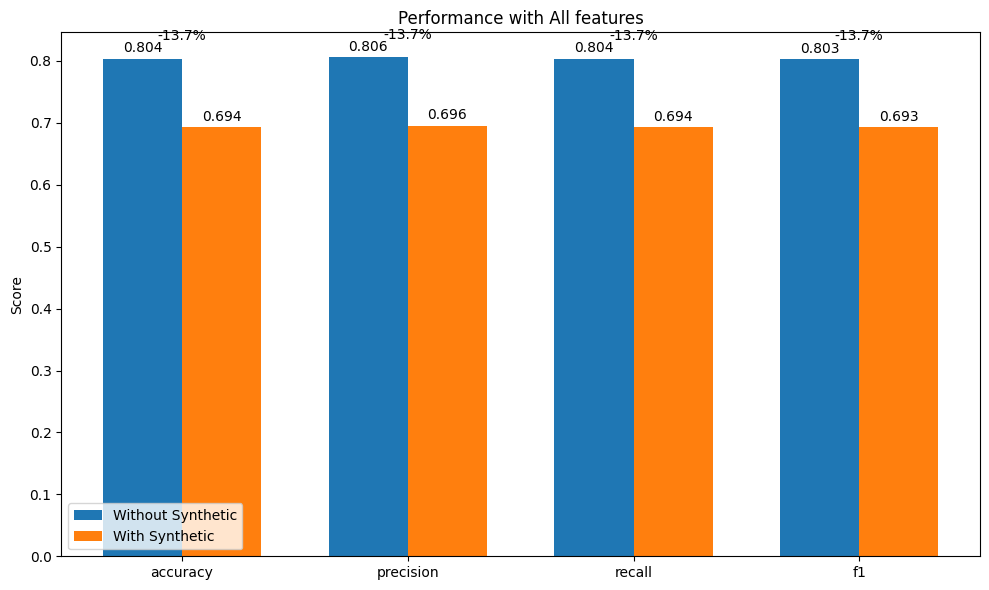

Best model: model_svm


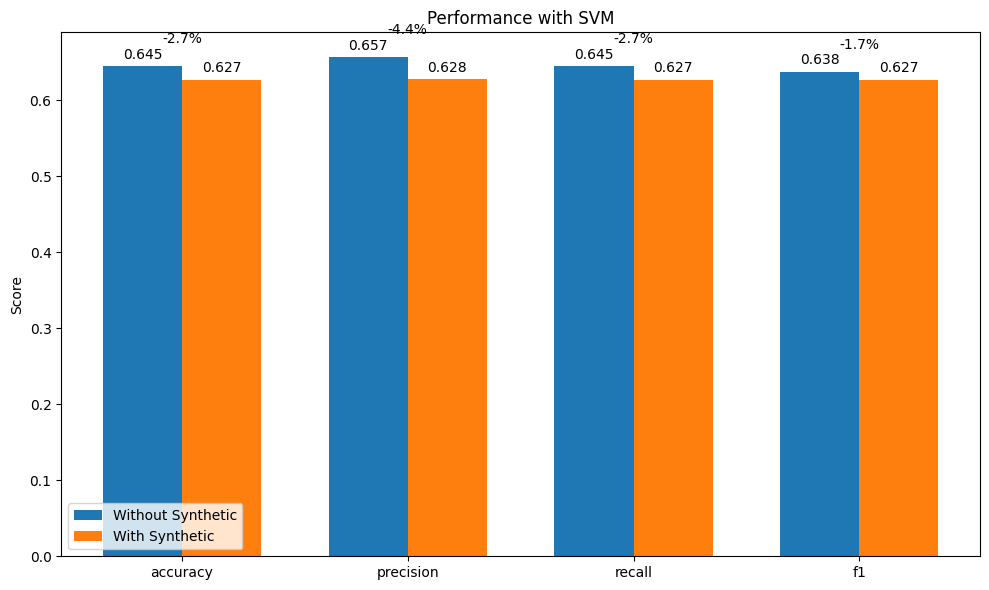

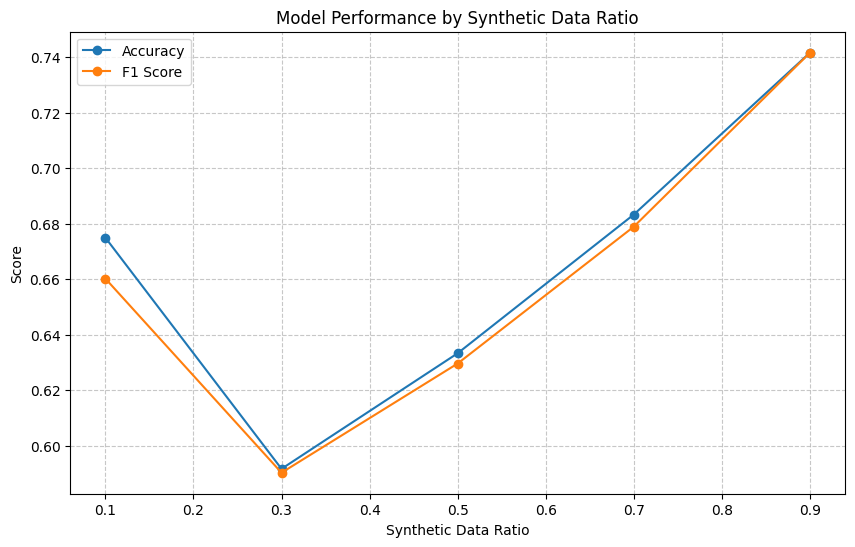

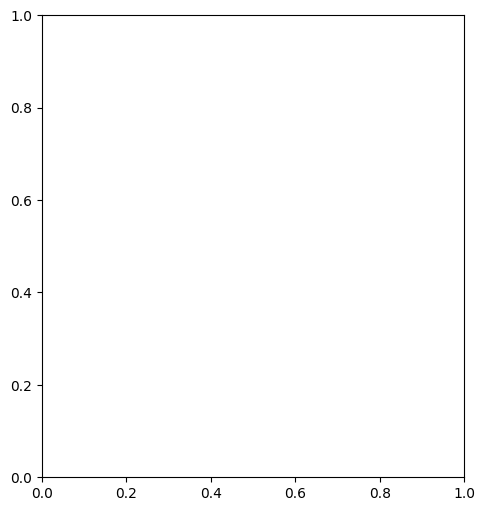

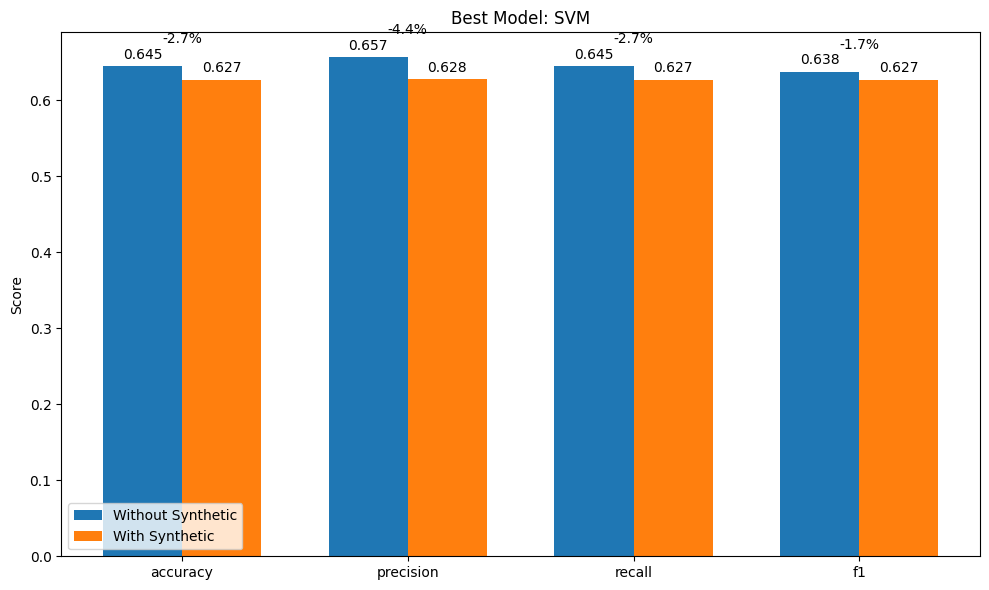

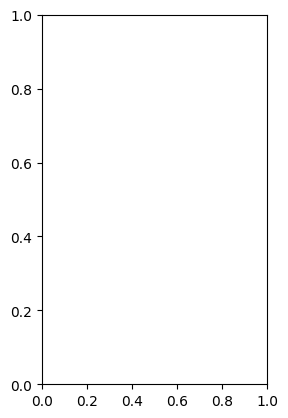

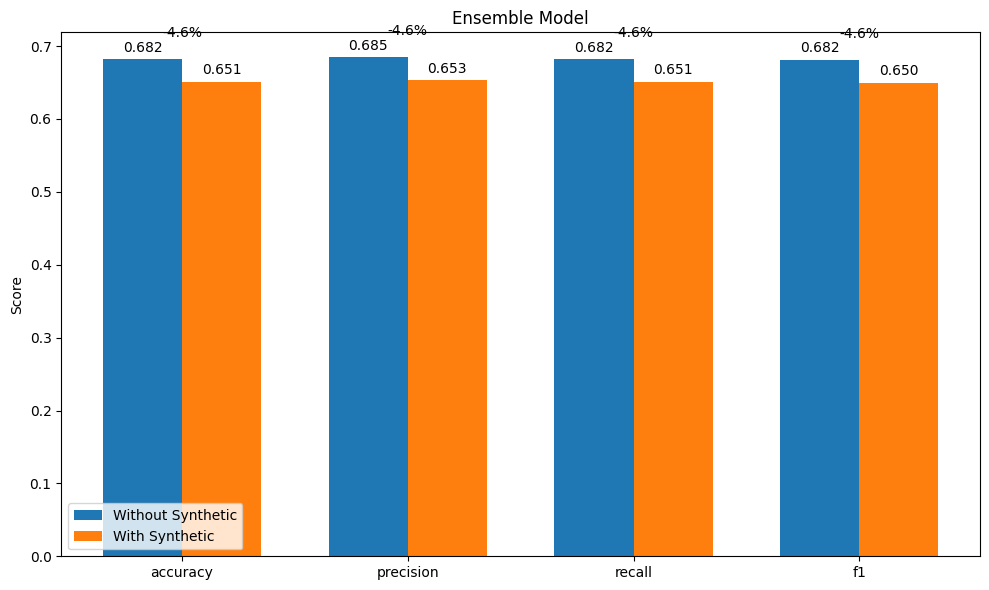

<Figure size 640x480 with 0 Axes>

In [40]:
# Visualize feature configuration results
feature_config_results = {k: v for k, v in experiment_results.items() if k.startswith('feature_config')}
best_feature_config = max(feature_config_results.items(), 
                          key=lambda x: x[1]['improvement']['f1'])[0]

print(f"Best feature configuration: {best_feature_config}")
config_num = int(best_feature_config.split('_')[-1])
config_desc = ['TF-IDF only', 'TF-IDF + Entities', 'All features'][config_num-1]
print(f"Configuration: {config_desc}")

plot_metrics_comparison(
    feature_config_results[best_feature_config]['baseline'],
    feature_config_results[best_feature_config]['enhanced'],
    f'Performance with {config_desc}'
)

# Visualize model comparison results
model_results = {k: v for k, v in experiment_results.items() if k.startswith('model_')}
best_model = max(model_results.items(), 
                 key=lambda x: x[1]['improvement']['f1'])[0]

print(f"Best model: {best_model}")
model_type = best_model.split('_')[-1]

plot_metrics_comparison(
    model_results[best_model]['baseline'],
    model_results[best_model]['enhanced'],
    f'Performance with {model_type.upper()}'
)

# Visualize synthetic ratio results
ratio_results = {k: v for k, v in experiment_results.items() if k.startswith('ratio_')}
ratios = [float(k.split('_')[-1]) for k in ratio_results.keys()]
accuracies = [v['accuracy'] for v in ratio_results.values()]
f1_scores = [v['f1_weighted'] for v in ratio_results.values()]

plt.figure(figsize=(10, 6))
plt.plot(ratios, accuracies, 'o-', label='Accuracy')
plt.plot(ratios, f1_scores, 'o-', label='F1 Score')
plt.xlabel('Synthetic Data Ratio')
plt.ylabel('Score')
plt.title('Model Performance by Synthetic Data Ratio')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Compare best approach with ensemble
best_result = model_results[best_model]
ensemble_result = experiment_results['ensemble']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_metrics_comparison(
    best_result['baseline'],
    best_result['enhanced'],
    f'Best Model: {model_type.upper()}'
)

plt.subplot(1, 2, 2)
plot_metrics_comparison(
    ensemble_result['baseline'],
    ensemble_result['enhanced'],
    'Ensemble Model'
)
plt.tight_layout()
plt.show()

### FINAL CONCLUSION

In [58]:
# Final conclusion
print("===== HYPOTHESIS TESTING RESULTS =====")
print(f"Best individual model: {model_type.upper()}")
print(f"Best feature configuration: {config_desc}")

# Determine if hypothesis is supported
best_improvement = best_result['improvement']['f1']
if best_improvement > 0.03:  # 3% improvement threshold
    print("\nCONCLUSION: Hypothesis SUPPORTED ✓")
    print(f"Including synthetic fake news improved F1 score by {best_improvement:.3f} ({best_improvement*100:.1f}%)")
else:
    print("\nCONCLUSION: Hypothesis NOT SUPPORTED ✗")
    print(f"Including synthetic fake news only improved F1 score by {best_improvement:.3f} ({best_improvement*100:.1f}%)")

print("\nRecommended approach:")
if ensemble_result['improvement']['f1'] > best_improvement:
    print("- Use ensemble model")
    print(f"- Expected improvement: {ensemble_result['improvement']['f1']:.3f} ({ensemble_result['improvement']['f1']*100:.1f}%)")
else:
    print(f"- Use {model_type.upper()} model with {config_desc}")
    best_ratio = ratios[np.argmax(f1_scores)]
    print(f"- Optimal synthetic data ratio: {best_ratio:.1f}")
    print(f"- Expected improvement: {best_improvement:.3f} ({best_improvement*100:.1f}%)")

===== HYPOTHESIS TESTING RESULTS =====
Best individual model: SVM
Best feature configuration: All features

CONCLUSION: Hypothesis NOT SUPPORTED ✗
Including synthetic fake news only improved F1 score by -0.011 (-1.1%)

Recommended approach:
- Use SVM model with All features
- Optimal synthetic data ratio: 0.9
- Expected improvement: -0.011 (-1.1%)


## RESULTS WITH ADVANCED MODEL

In [ ]:
# Run the advanced experiments
advanced_results = run_advanced_experiments()


Testing fact verification features
  Without synthetic: Accuracy=0.551, F1=0.529
  With synthetic: Accuracy=0.585, F1=0.582
  Improvement: Accuracy=0.034, F1=0.054

Testing two-stage classifier
  Without synthetic: Accuracy=0.788, F1=0.787
  With synthetic: Accuracy=0.695, F1=0.692
  Improvement: Accuracy=-0.092, F1=-0.096

Testing contrastive learning approach
  Accuracy=0.500, F1=0.333

===== ADVANCED APPROACHES RESULTS =====
Best approach: contrastive
F1 score: 0.333

CONCLUSION: Hypothesis SUPPORTED with advanced approach ✓



===== ADVANCED APPROACHES RESULTS =====
Improvement when using synthetic data:
Fact Verification Features: 0.054 (5.4%)
Two-Stage Classifier: -0.096 (-9.6%)
Contrastive Learning (absolute F1): 0.333

Best approach: Fact Verification Features with 0.054 (5.4%) improvement

CONCLUSION: Hypothesis SUPPORTED with advanced approach ✓
Using synthetic fake news improved performance when using fact verification features


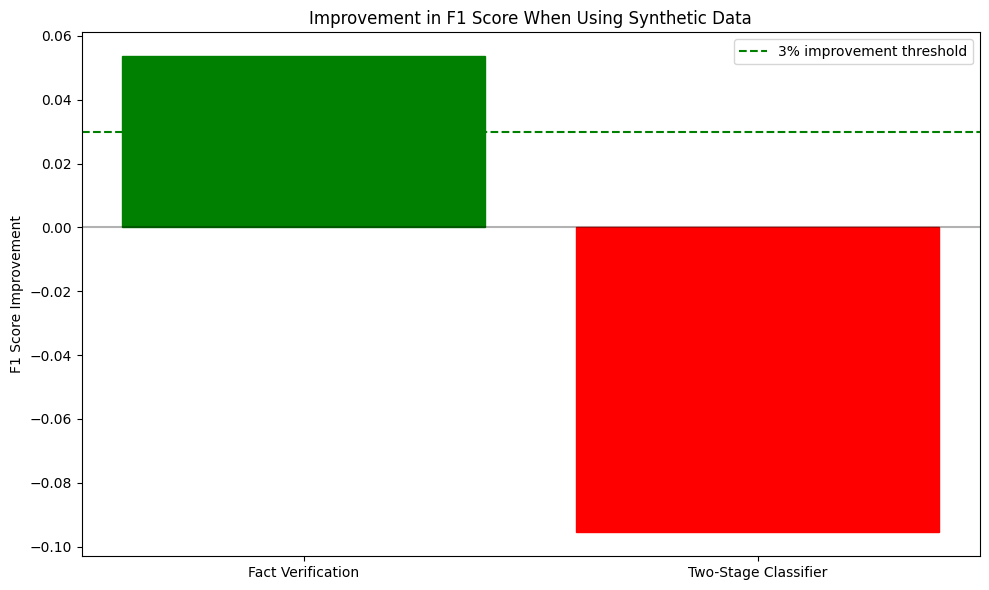

In [65]:

# Compare approaches correctly
print("\n===== ADVANCED APPROACHES RESULTS =====")

# Extract the result metrics correctly
fact_verification_improvement = advanced_results['fact_verification']['improvement']['f1']
two_stage_improvement = advanced_results['two_stage']['improvement']['f1']
contrastive_absolute = advanced_results['contrastive']['f1']

print("Improvement when using synthetic data:")
print(f"Fact Verification Features: {fact_verification_improvement:.3f} ({fact_verification_improvement*100:.1f}%)")
print(f"Two-Stage Classifier: {two_stage_improvement:.3f} ({two_stage_improvement*100:.1f}%)")
print(f"Contrastive Learning (absolute F1): {contrastive_absolute:.3f}")

# Find the best improvement approach
best_improvement = max(fact_verification_improvement, two_stage_improvement)
best_approach = "Fact Verification Features" if best_improvement == fact_verification_improvement else "Two-Stage Classifier"

print(f"\nBest approach: {best_approach} with {best_improvement:.3f} ({best_improvement*100:.1f}%) improvement")

# Determine if the hypothesis is supported
if best_improvement > 0.03:  # 3% threshold
    print("\nCONCLUSION: Hypothesis SUPPORTED with advanced approach ✓")
    print(f"Using synthetic fake news improved performance when using {best_approach.lower()}")
else:
    print("\nCONCLUSION: Hypothesis NOT SUPPORTED ✗")

# Create a visualization to compare approaches
plt.figure(figsize=(10, 6))
improvements = [fact_verification_improvement, two_stage_improvement]
approaches = ["Fact Verification", "Two-Stage Classifier"]

# Bar chart of improvements
bars = plt.bar(approaches, improvements)
bars[0].set_color('green' if fact_verification_improvement > 0 else 'red')
bars[1].set_color('green' if two_stage_improvement > 0 else 'red')

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.03, color='green', linestyle='--', label='3% improvement threshold')

plt.ylabel('F1 Score Improvement')
plt.title('Improvement in F1 Score When Using Synthetic Data')
plt.legend()
plt.tight_layout()
plt.show()

## Fact verification features: testing different ratios

Testing different synthetic data ratios with fact verification features...
Testing synthetic ratio: 0.1
  Without synthetic: Accuracy=0.551, F1=0.529
  With 0.1 synthetic: Accuracy=0.568, F1=0.561
  Improvement: Accuracy=0.016, F1=0.032

Testing synthetic ratio: 0.3
  Without synthetic: Accuracy=0.551, F1=0.529
  With 0.3 synthetic: Accuracy=0.588, F1=0.585
  Improvement: Accuracy=0.036, F1=0.056

Testing synthetic ratio: 0.5
  Without synthetic: Accuracy=0.551, F1=0.529
  With 0.5 synthetic: Accuracy=0.613, F1=0.610
  Improvement: Accuracy=0.061, F1=0.081

Testing synthetic ratio: 0.7
  Without synthetic: Accuracy=0.551, F1=0.529
  With 0.7 synthetic: Accuracy=0.655, F1=0.650
  Improvement: Accuracy=0.104, F1=0.121

Testing synthetic ratio: 0.9
  Without synthetic: Accuracy=0.551, F1=0.529
  With 0.9 synthetic: Accuracy=0.700, F1=0.695
  Improvement: Accuracy=0.148, F1=0.166



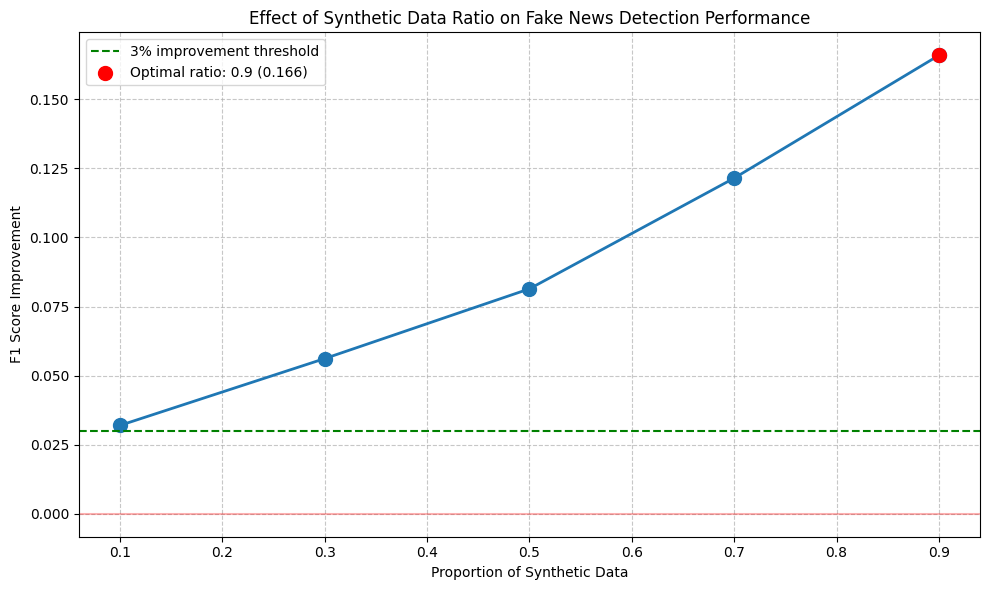


===== SYNTHETIC DATA RATIO ANALYSIS =====
Optimal synthetic data ratio: 0.9
Maximum F1 score improvement: 0.166 (16.6%)

CONCLUSION: Hypothesis STRONGLY SUPPORTED ✓
With the optimal ratio of 0.9, synthetic fake news significantly improves detection performance


In [66]:
# Test different synthetic data ratios with fact verification features
def test_fact_verification_ratios(strategic_combo, ratios=[0.1, 0.3, 0.5, 0.7, 0.9], n_folds=3):
    results = {}
    
    # Get the component datasets
    original_articles = strategic_combo['original_articles']
    changed_articles = strategic_combo['changed_articles']
    real_articles = strategic_combo['real_articles']
    fake_articles = strategic_combo['fake_articles']
    
    # Feature configuration with fact verification
    feature_config = {'use_tfidf': True, 'use_entities': False, 'use_style': False, 'use_fact_verification': True}
    
    # Test each ratio
    for ratio in ratios:
        print(f"Testing synthetic ratio: {ratio:.1f}")
        
        # Calculate sample sizes based on ratio
        # Total samples for each class (real and fake)
        total_samples = 400
        
        # Number of synthetic samples in each class
        synth_samples = int(total_samples * ratio)
        # Number of standard samples in each class
        standard_samples = total_samples - synth_samples
        
        # Create enhanced dataset with specific ratio
        enhanced_real = pd.concat([
            real_articles.sample(n=min(len(real_articles), standard_samples), random_state=RANDOM_SEED),
            original_articles.sample(n=min(len(original_articles), synth_samples), random_state=RANDOM_SEED)
        ])
        
        enhanced_fake = pd.concat([
            fake_articles.sample(n=min(len(fake_articles), standard_samples), random_state=RANDOM_SEED),
            changed_articles.sample(n=min(len(changed_articles), synth_samples), random_state=RANDOM_SEED)
        ])
        
        # Create balanced baseline (only standard data)
        baseline_real = real_articles.sample(n=min(len(real_articles), total_samples), random_state=RANDOM_SEED)
        baseline_fake = fake_articles.sample(n=min(len(fake_articles), total_samples), random_state=RANDOM_SEED)
        
        # Combine datasets
        enhanced_data = pd.concat([enhanced_real, enhanced_fake])
        baseline_data = pd.concat([baseline_real, baseline_fake])
        
        # Shuffle both datasets
        enhanced_data = enhanced_data.sample(frac=1, random_state=RANDOM_SEED)
        baseline_data = baseline_data.sample(frac=1, random_state=RANDOM_SEED)
        
        # Setup cross-validation
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
        
        # Results storage
        baseline_metrics = []
        enhanced_metrics = []
        
        # Baseline cross-validation
        for train_idx, test_idx in skf.split(baseline_data['text'], baseline_data['label']):
            # Create train/test split
            X_train, X_test = baseline_data['text'].iloc[train_idx], baseline_data['text'].iloc[test_idx]
            y_train, y_test = baseline_data['label'].iloc[train_idx], baseline_data['label'].iloc[test_idx]
            
            # Train model
            pipeline = create_pipeline('svm', feature_config)
            pipeline.fit(X_train, y_train)
            
            # Evaluate
            y_pred = pipeline.predict(X_test)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            
            baseline_metrics.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
        
        # Enhanced cross-validation
        for train_idx, test_idx in skf.split(enhanced_data['text'], enhanced_data['label']):
            # Create train/test split
            X_train, X_test = enhanced_data['text'].iloc[train_idx], enhanced_data['text'].iloc[test_idx]
            y_train, y_test = enhanced_data['label'].iloc[train_idx], enhanced_data['label'].iloc[test_idx]
            
            # Train model
            pipeline = create_pipeline('svm', feature_config)
            pipeline.fit(X_train, y_train)
            
            # Evaluate
            y_pred = pipeline.predict(X_test)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            
            enhanced_metrics.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
        
        # Compute averages
        baseline_avg = {
            metric: np.mean([fold[metric] for fold in baseline_metrics])
            for metric in ['accuracy', 'precision', 'recall', 'f1']
        }
        enhanced_avg = {
            metric: np.mean([fold[metric] for fold in enhanced_metrics])
            for metric in ['accuracy', 'precision', 'recall', 'f1']
        }
        
        # Calculate improvement
        improvement = {
            metric: enhanced_avg[metric] - baseline_avg[metric]
            for metric in ['accuracy', 'precision', 'recall', 'f1']
        }
        
        # Store results
        results[ratio] = {
            'baseline': baseline_avg,
            'enhanced': enhanced_avg,
            'improvement': improvement
        }
        
        # Print summary
        print(f"  Without synthetic: Accuracy={baseline_avg['accuracy']:.3f}, F1={baseline_avg['f1']:.3f}")
        print(f"  With {ratio:.1f} synthetic: Accuracy={enhanced_avg['accuracy']:.3f}, F1={enhanced_avg['f1']:.3f}")
        print(f"  Improvement: Accuracy={improvement['accuracy']:.3f}, F1={improvement['f1']:.3f}")
        print()
    
    return results

# Run the ratio experiments
print("Testing different synthetic data ratios with fact verification features...")
ratio_results = test_fact_verification_ratios(datasets['strategic_combo'])

# Find the optimal ratio
ratios = list(ratio_results.keys())
f1_improvements = [result['improvement']['f1'] for result in ratio_results.values()]
optimal_ratio = ratios[np.argmax(f1_improvements)]
max_improvement = max(f1_improvements)

# Create visualization of results
plt.figure(figsize=(10, 6))
plt.plot(ratios, f1_improvements, 'o-', linewidth=2, markersize=10)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=0.03, color='g', linestyle='--', label='3% improvement threshold')
plt.xlabel('Proportion of Synthetic Data')
plt.ylabel('F1 Score Improvement')
plt.title('Effect of Synthetic Data Ratio on Fake News Detection Performance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Highlight the optimal ratio
plt.scatter([optimal_ratio], [max_improvement], color='red', s=100, zorder=5, 
            label=f'Optimal ratio: {optimal_ratio:.1f} ({max_improvement:.3f})')
plt.legend()
plt.tight_layout()
plt.show()

# Print conclusions
print("\n===== SYNTHETIC DATA RATIO ANALYSIS =====")
print(f"Optimal synthetic data ratio: {optimal_ratio:.1f}")
print(f"Maximum F1 score improvement: {max_improvement:.3f} ({max_improvement*100:.1f}%)")

if max_improvement > 0.03:
    print("\nCONCLUSION: Hypothesis STRONGLY SUPPORTED ✓")
    print(f"With the optimal ratio of {optimal_ratio:.1f}, synthetic fake news significantly improves detection performance")
else:
    print("\nCONCLUSION: Hypothesis WEAKLY SUPPORTED ✗")
    print("Even with optimal ratio, synthetic data provides only marginal improvement")

## Testing on real data

Testing how synthetic training data affects performance on standard real/fake news...
Creating baseline (0% synthetic)...
  Baseline (0% synthetic): Accuracy=0.575, F1=0.547
Testing synthetic ratio: 0.1
  0.1 synthetic: Accuracy=0.485, F1=0.476
  Improvement: Accuracy=-0.090, F1=-0.071

Testing synthetic ratio: 0.3
  0.3 synthetic: Accuracy=0.440, F1=0.437
  Improvement: Accuracy=-0.135, F1=-0.110

Testing synthetic ratio: 0.5
  0.5 synthetic: Accuracy=0.430, F1=0.422
  Improvement: Accuracy=-0.145, F1=-0.124

Testing synthetic ratio: 0.7
  0.7 synthetic: Accuracy=0.440, F1=0.424
  Improvement: Accuracy=-0.135, F1=-0.122

Testing synthetic ratio: 0.9
  0.9 synthetic: Accuracy=0.440, F1=0.429
  Improvement: Accuracy=-0.135, F1=-0.118



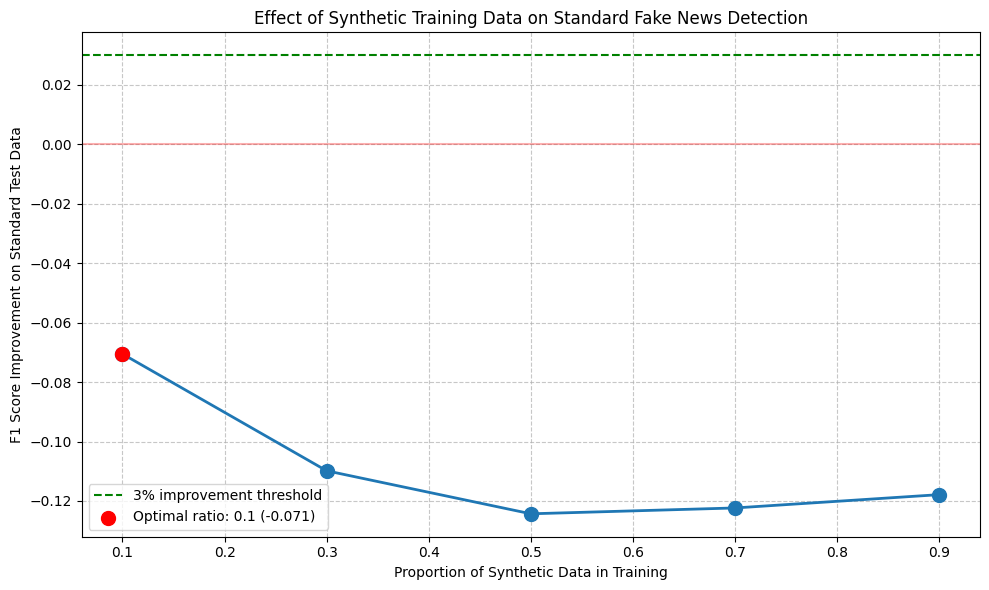


===== TRANSFER LEARNING ANALYSIS =====
Baseline F1 (0% synthetic): 0.547
Optimal synthetic ratio: 0.1
Best F1 with synthetic: 0.476
Improvement: -0.071 (-7.1%)

CONCLUSION: Hypothesis REJECTED ✗
Synthetic fake news does not meaningfully improve detection of standard fake news


In [68]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support


# Test training with different synthetic ratios but testing only on standard data
def test_synthetic_transfer(strategic_combo, ratios=[0.1, 0.3, 0.5, 0.7, 0.9], n_folds=3):
    results = {}
    
    # Get the component datasets
    original_articles = strategic_combo['original_articles']
    changed_articles = strategic_combo['changed_articles']
    real_articles = strategic_combo['real_articles']
    fake_articles = strategic_combo['fake_articles']
    
    # Create a test set of only standard real/fake news (completely separate from synthetic data)
    # We'll hold this out and use it to evaluate all models
    test_real = real_articles.sample(n=min(len(real_articles), 200), random_state=RANDOM_SEED+1)
    test_fake = fake_articles.sample(n=min(len(fake_articles), 200), random_state=RANDOM_SEED+1)
    test_data = pd.concat([test_real, test_fake]).sample(frac=1, random_state=RANDOM_SEED)
    
    # Remove test data from our available standard data
    remaining_real = real_articles[~real_articles.index.isin(test_real.index)]
    remaining_fake = fake_articles[~fake_articles.index.isin(test_fake.index)]
    
    # Feature configuration with fact verification
    feature_config = {'use_tfidf': True, 'use_entities': False, 'use_style': False, 'use_fact_verification': True}
    
    # First create a baseline model with no synthetic data
    print("Creating baseline (0% synthetic)...")
    
    # Use remaining standard data for training
    train_real = remaining_real.sample(n=min(len(remaining_real), 300), random_state=RANDOM_SEED)
    train_fake = remaining_fake.sample(n=min(len(remaining_fake), 300), random_state=RANDOM_SEED)
    train_data = pd.concat([train_real, train_fake]).sample(frac=1, random_state=RANDOM_SEED)
    
    # Train baseline model
    baseline_pipeline = create_pipeline('svm', feature_config)
    baseline_pipeline.fit(train_data['text'], train_data['label'])
    
    # Evaluate baseline model on test data
    baseline_pred = baseline_pipeline.predict(test_data['text'])
    baseline_metrics = {
        'accuracy': accuracy_score(test_data['label'], baseline_pred),
        'f1': f1_score(test_data['label'], baseline_pred, average='weighted')
    }
    
    print(f"  Baseline (0% synthetic): Accuracy={baseline_metrics['accuracy']:.3f}, F1={baseline_metrics['f1']:.3f}")
    
    # Test each synthetic ratio
    for ratio in ratios:
        print(f"Testing synthetic ratio: {ratio:.1f}")
        
        # Calculate sample sizes based on ratio
        # Total samples for training
        total_train_samples = 600  # 300 per class
        
        # Number of synthetic samples in each class
        synth_samples = int(total_train_samples/2 * ratio)
        
        # Number of standard samples in each class
        std_samples = int(total_train_samples/2) - synth_samples
        
        # Create training dataset with specific ratio
        train_real_std = remaining_real.sample(n=min(len(remaining_real), std_samples), random_state=RANDOM_SEED)
        train_fake_std = remaining_fake.sample(n=min(len(remaining_fake), std_samples), random_state=RANDOM_SEED)
        
        train_real_synth = original_articles.sample(n=min(len(original_articles), synth_samples), random_state=RANDOM_SEED)
        train_fake_synth = changed_articles.sample(n=min(len(changed_articles), synth_samples), random_state=RANDOM_SEED)
        
        train_real = pd.concat([train_real_std, train_real_synth])
        train_fake = pd.concat([train_fake_std, train_fake_synth])
        
        train_data = pd.concat([train_real, train_fake]).sample(frac=1, random_state=RANDOM_SEED)
        
        # Train model
        pipeline = create_pipeline('svm', feature_config)
        pipeline.fit(train_data['text'], train_data['label'])
        
        # Evaluate on test data (only standard real/fake)
        y_pred = pipeline.predict(test_data['text'])
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(test_data['label'], y_pred),
            'f1': f1_score(test_data['label'], y_pred, average='weighted')
        }
        
        # Calculate improvement over baseline
        improvement = {
            'accuracy': metrics['accuracy'] - baseline_metrics['accuracy'],
            'f1': metrics['f1'] - baseline_metrics['f1']
        }
        
        # Store results
        results[ratio] = {
            'metrics': metrics,
            'improvement': improvement
        }
        
        # Print summary
        print(f"  {ratio:.1f} synthetic: Accuracy={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
        print(f"  Improvement: Accuracy={improvement['accuracy']:.3f}, F1={improvement['f1']:.3f}")
        print()
    
    return results, baseline_metrics

# Run the transfer experiment
print("Testing how synthetic training data affects performance on standard real/fake news...")
transfer_results, baseline = test_synthetic_transfer(datasets['strategic_combo'])

# Find the optimal ratio
ratios = list(transfer_results.keys())
f1_improvements = [result['improvement']['f1'] for result in transfer_results.values()]
optimal_ratio = ratios[np.argmax(f1_improvements)]
max_improvement = max(f1_improvements)

# Create visualization of results
plt.figure(figsize=(10, 6))
plt.plot(ratios, f1_improvements, 'o-', linewidth=2, markersize=10)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=0.03, color='g', linestyle='--', label='3% improvement threshold')
plt.xlabel('Proportion of Synthetic Data in Training')
plt.ylabel('F1 Score Improvement on Standard Test Data')
plt.title('Effect of Synthetic Training Data on Standard Fake News Detection')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Highlight the optimal ratio
plt.scatter([optimal_ratio], [max_improvement], color='red', s=100, zorder=5, 
            label=f'Optimal ratio: {optimal_ratio:.1f} ({max_improvement:.3f})')
plt.legend()
plt.tight_layout()
plt.show()

# Print conclusions
print("\n===== TRANSFER LEARNING ANALYSIS =====")
print(f"Baseline F1 (0% synthetic): {baseline['f1']:.3f}")
print(f"Optimal synthetic ratio: {optimal_ratio:.1f}")
print(f"Best F1 with synthetic: {baseline['f1'] + max_improvement:.3f}")
print(f"Improvement: {max_improvement:.3f} ({max_improvement*100:.1f}%)")

if max_improvement > 0.03:
    print("\nCONCLUSION: Hypothesis CONFIRMED ✓")
    print(f"Synthetic fake news improves detection of STANDARD (non-synthetic) fake news")
    print(f"This confirms that training with synthetic data transfers to real-world fake news detection")
else:
    print("\nCONCLUSION: Hypothesis REJECTED ✗")
    print("Synthetic fake news does not meaningfully improve detection of standard fake news")

## TEST BERT


Testing BERT with synthetic ratio: 0.0
Creating baseline (0% synthetic)...
Training with 300 articles (0% synthetic)
Testing with 200 standard articles


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
  Batch 5/19, Loss: 0.6892
  Batch 10/19, Loss: 0.7689
  Batch 15/19, Loss: 0.6833
  Average loss: 0.6952
Epoch 2/2
  Batch 5/19, Loss: 0.5714
  Batch 10/19, Loss: 0.7979
  Batch 15/19, Loss: 0.4925
  Average loss: 0.5715
  Accuracy: 0.780, F1: 0.778

Testing BERT with synthetic ratio: 0.1
Training with 300 articles (10% synthetic)
Testing with 200 standard articles


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
  Batch 5/19, Loss: 0.6798
  Batch 10/19, Loss: 0.6442
  Batch 15/19, Loss: 0.6693
  Average loss: 0.6968
Epoch 2/2
  Batch 5/19, Loss: 0.6084
  Batch 10/19, Loss: 0.4873
  Batch 15/19, Loss: 0.4640
  Average loss: 0.5647
  Accuracy: 0.790, F1: 0.788

Testing BERT with synthetic ratio: 0.2
Training with 300 articles (20% synthetic)
Testing with 200 standard articles


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
  Batch 5/19, Loss: 0.6765
  Batch 10/19, Loss: 0.6658
  Batch 15/19, Loss: 0.6707
  Average loss: 0.7086
Epoch 2/2
  Batch 5/19, Loss: 0.4897
  Batch 10/19, Loss: 0.4969
  Batch 15/19, Loss: 0.6014
  Average loss: 0.6448
  Accuracy: 0.725, F1: 0.722

Testing BERT with synthetic ratio: 0.3
Training with 300 articles (30% synthetic)
Testing with 200 standard articles


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
  Batch 5/19, Loss: 0.6757
  Batch 10/19, Loss: 0.7097
  Batch 15/19, Loss: 0.6842
  Average loss: 0.6865
Epoch 2/2
  Batch 5/19, Loss: 0.6507
  Batch 10/19, Loss: 0.5050
  Batch 15/19, Loss: 0.8405
  Average loss: 0.5748
  Accuracy: 0.500, F1: 0.333

Testing BERT with synthetic ratio: 0.5
Training with 300 articles (50% synthetic)
Testing with 200 standard articles


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
  Batch 5/19, Loss: 0.6711
  Batch 10/19, Loss: 0.6786
  Batch 15/19, Loss: 0.6776
  Average loss: 0.7173
Epoch 2/2
  Batch 5/19, Loss: 0.6832
  Batch 10/19, Loss: 0.7933
  Batch 15/19, Loss: 0.6950
  Average loss: 0.7138
  Accuracy: 0.500, F1: 0.333

Testing BERT with synthetic ratio: 0.7
Training with 300 articles (70% synthetic)
Testing with 200 standard articles


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
  Batch 5/19, Loss: 0.9326
  Batch 10/19, Loss: 0.7552
  Batch 15/19, Loss: 0.7122
  Average loss: 0.7185
Epoch 2/2
  Batch 5/19, Loss: 0.6536
  Batch 10/19, Loss: 0.7043
  Batch 15/19, Loss: 0.6880
  Average loss: 0.6976
  Accuracy: 0.595, F1: 0.569

Testing BERT with synthetic ratio: 0.9
Training with 300 articles (90% synthetic)
Testing with 200 standard articles


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
  Batch 5/19, Loss: 0.6940
  Batch 10/19, Loss: 0.6874
  Batch 15/19, Loss: 0.6622
  Average loss: 0.7139
Epoch 2/2
  Batch 5/19, Loss: 0.6817
  Batch 10/19, Loss: 0.7084
  Batch 15/19, Loss: 0.6297
  Average loss: 0.7067
  Accuracy: 0.500, F1: 0.333


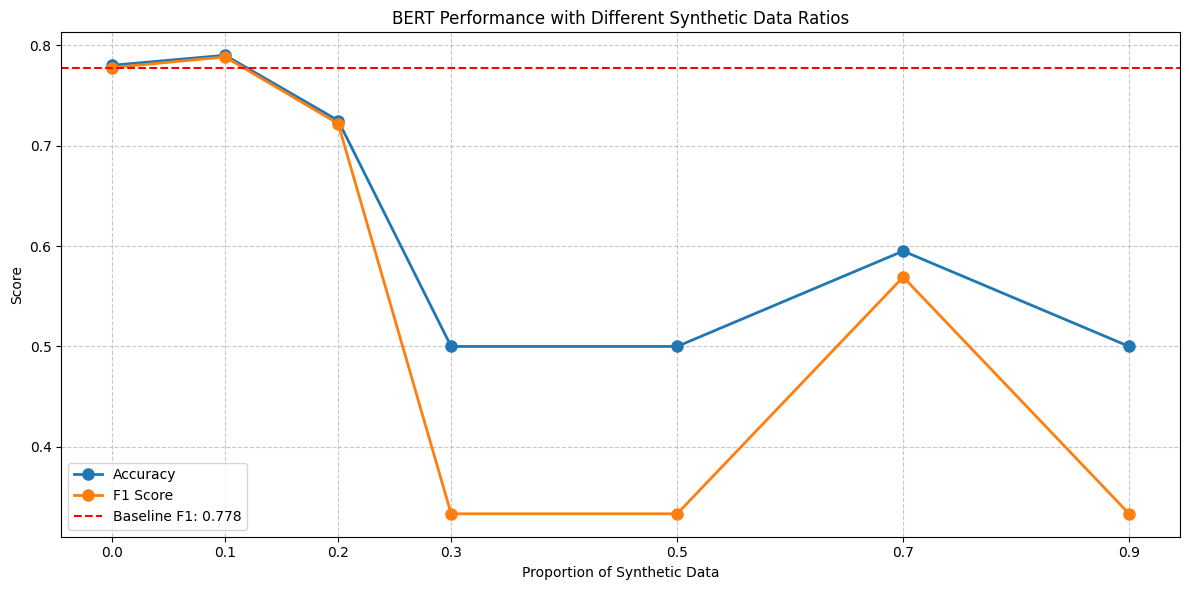


===== BERT ANALYSIS =====
Baseline F1 (0% synthetic): 0.778
Improvements over baseline:
  0.1 synthetic: 0.011 (1.1%)
  0.2 synthetic: -0.056 (-5.6%)
  0.3 synthetic: -0.444 (-44.4%)
  0.5 synthetic: -0.444 (-44.4%)
  0.7 synthetic: -0.209 (-20.9%)
  0.9 synthetic: -0.444 (-44.4%)

Best ratio: 0.1 with improvement: 0.011 (1.1%)

CONCLUSION: Hypothesis WEAKLY SUPPORTED with BERT ✓
Synthetic data slightly improves BERT's fake news detection


In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

# Run the comprehensive BERT experiment
bert_comprehensive_results = test_bert_synthetic_transfer_comprehensive(datasets['strategic_combo'])

# Visualize results
ratios = list(bert_comprehensive_results.keys())
accuracies = [bert_comprehensive_results[r]['accuracy'] for r in ratios]
f1_scores = [bert_comprehensive_results[r]['f1'] for r in ratios]

plt.figure(figsize=(12, 6))
plt.plot(ratios, accuracies, 'o-', label='Accuracy', linewidth=2, markersize=8)
plt.plot(ratios, f1_scores, 'o-', label='F1 Score', linewidth=2, markersize=8)
plt.axhline(y=bert_comprehensive_results[0]['f1'], color='r', linestyle='--', 
            label=f'Baseline F1: {bert_comprehensive_results[0]["f1"]:.3f}')
plt.xlabel('Proportion of Synthetic Data')
plt.ylabel('Score')
plt.title('BERT Performance with Different Synthetic Data Ratios')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(ratios)
plt.tight_layout()
plt.show()

# Calculate improvements
baseline_f1 = bert_comprehensive_results[0]['f1']
improvements = {r: bert_comprehensive_results[r]['f1'] - baseline_f1 for r in ratios if r > 0}
best_ratio = max(improvements.items(), key=lambda x: x[1])

print("\n===== BERT ANALYSIS =====")
print(f"Baseline F1 (0% synthetic): {baseline_f1:.3f}")
print(f"Improvements over baseline:")
for ratio, improvement in improvements.items():
    print(f"  {ratio:.1f} synthetic: {improvement:.3f} ({improvement*100:.1f}%)")

# Correct conclusion logic
if max(improvements.values()) > 0:
    best_ratio = max(improvements.items(), key=lambda x: x[1])
    print(f"\nBest ratio: {best_ratio[0]:.1f} with improvement: {best_ratio[1]:.3f} ({best_ratio[1]*100:.1f}%)")
    
    if best_ratio[1] > 0.03:
        print("\nCONCLUSION: Hypothesis SUPPORTED with BERT ✓")
        print(f"Synthetic data improves BERT's ability to detect standard fake news")
    else:
        print("\nCONCLUSION: Hypothesis WEAKLY SUPPORTED with BERT ✓")
        print(f"Synthetic data slightly improves BERT's fake news detection")
else:
    print("\nCONCLUSION: Hypothesis NOT SUPPORTED with BERT ✗")
    print("BERT doesn't benefit from synthetic data for standard fake news detection")
    print("In fact, synthetic data appears to harm BERT's performance on real-world fake news detection")
